# **Crime and the Coronavirus Pandemic**
## Effects of COVID-19 Lockdown Protocols on Crime Rates in Vancouver and Vancouver Neighbourhoods

#### STAT 201 - Group 17
#### Authors: Yuening Lu, Ibrahim Saeed, Julia Sangster, Yelia Ye
***

# **Introduction**
***

In January 2020, COVID-19 entered Canada [1]. To combat the effects of the pandemic, the city of Vancouver had lockdown protocols in place over three periods [1,2].

* Lockdown Period 1: March 12, 2020 - June 24, 2020
* Lockdown Period 2: November 7, 2020 - June 15, 2021
* Lockdown Period 3: December 20, 2021 - January 20, 2022

There are studies that compare the crime rates before and after the pandemic period to see how COVID-19 affected crime [3]. Often these studies claim to be studying lockdown periods vs. non-lockdown periods, but broadly compare the rate of crime in years prior to the COVID-19 pandemic (~ 2016 - 2020) to the rate in years after (in 2020 - present) [3]. The aim of this project is to investigate if lockdown alone is associated with a change in daily crime rates in Vancouver. 

The Vancouver Police Department (VPD) collects crime statistics for Vancouver, including the type of crime, the neighbourhood it was committed in, and the date of offense [4]. This data set can be used to obtain the median daily crime rate in Vancouver, which is a useful measure of the typical crime rate in both skewed and normal distributed data. Standard error in the sample median will be used as the scale parameter for analysis, as a measure of variation in sampling. 

The project will utilise the dataset to answer the following question: was the daily median crime rate in Vancouver different for lockdown days vs. non-lockdown days over the period of 2020 - 2022? This question will be investigated for Vancouver overall, and then further for specific neighbourhoods.

# **Methods and Results**
***

## **Notebook Setup**

In [1]:
## This cell does all set-up steps for analysis

## Uncomment and run these lines if the needed packages are not installed in your IDE
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("tidymodels")
#install.packages("broom")
#install.packages("cowplot")


## The following lines load the relevant packages
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(infer))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(cowplot))

## Reduces default table-output size
options(repr.matrix.max.rows = 6)

## Sets RNG seed for the page
set.seed(9999)

## Sets a general theme for plot output 
theme_set(theme_bw())

## **Reading Data from Repository**

Data was obtained from the VCD GeoDash repository [4]. The cell below reads the data into the current R kernel.

In [2]:
suppressWarnings({
    
    ## These cells read in the crime database over 2020 and 2021
    data_2022 <- read_csv("https://raw.githubusercontent.com/juliasangster/STAT_201_Project/main/crimedata_csv_AllNeighbourhoods_2022.csv", show_col_types = FALSE)
    data_2021 <- read_csv("https://raw.githubusercontent.com/juliasangster/STAT_201_Project/main/crimedata_csv_AllNeighbourhoods_2021.csv", show_col_types = FALSE)
    data_2020 <- read_csv("https://raw.githubusercontent.com/juliasangster/STAT_201_Project/main/crimedata_csv_AllNeighbourhoods_2020.csv", show_col_types = FALSE)
    
    ## These cells combine the data into a single dataframe, and remove irrelevant columns
    all_data <- rbind(data_2022, data_2021, data_2020)
    
    ## This will show a single-row output, to confirm dataset was loaded
    head(all_data, n =1)
    
    })

TYPE                       YEAR MONTH DAY HOUR MINUTE HUNDRED_BLOCK  
1 Break and Enter Commercial 2022 1     3   16   19     10XX ALBERNI ST
  NEIGHBOURHOOD X        Y      
1 West End      491036.1 5459146

## **Cleaning/Wrangling Data**

The following cleaning/wrangling steps were taken:
1. Selected only relevant columns (`YEAR`, `MONTH`, `DAY`, `NEIGHBOURHOOD`)
2. Filtered data to remove `NA` values over all columns
3. Converted `NEIGHBOURHOOD` column  to `fct` data type
4. Filtered data into lockdown/non-lockdown crime days
5. Created a new column indicating lockdown status `lockdown`
6. Combined data sets to create final, clean data set `all_data_tidy_w_lockdown`

In [3]:
## Step 1: Selecting only relevant columns 
all_data_tidy <- all_data |>
    select(YEAR, MONTH, DAY, NEIGHBOURHOOD)

In [4]:
## Step 2: Filtering NA Values
all_data_tidy <- all_data_tidy |>
    filter(!(is.na(YEAR))) |>
    filter(!(is.na(DAY)))  |>
    filter(!(is.na(NEIGHBOURHOOD)))

In [5]:
## Step 3: Converting NEIGHBOURHOOD to fct type
all_data_tidy$NEIGHBOURHOOD <- as.factor(all_data_tidy$NEIGHBOURHOOD)

In [6]:
## Step 4/5: Filter non-lockdown and lockdown days, and create 
##           column representing this with "mutate"

## creates dataset with "yes" column, for lockdown days 
all_data_lockdown <- all_data_tidy |>
    filter((YEAR >= 2020 & MONTH >= 3)  &                    ## Selects days after February 3rd/2020
          ((YEAR == 2020 & MONTH == 3   &      DAY >= 12)  | ## First Lockdown Starts: March 12/2020
           (YEAR == 2020 & MONTH %in% c(4,5))              | ## 
           (YEAR == 2020 & MONTH == 6   &      DAY < 25)   | ## First Lockdown Ends: June 24/2020 
           (YEAR == 2020 & MONTH == 11  &      DAY >= 7)   | ## Second Lockdown Starts: Nov. 7/2020
           (YEAR == 2020 & MONTH == 12)                    | ## 
           (YEAR == 2021 & MONTH %in% c(1,2,3,4,5))        | ##
           (YEAR == 2021 & MONTH == 6   &      DAY <= 15)  | ## Second Lockdown Ends: June 15/2021
           (YEAR == 2021 & MONTH == 12  &      DAY >= 20)  | ## Third Lockdown Starts: Dec. 20/2021
           (YEAR == 2022 & MONTH == 1   &      DAY <= 20)))|>## Third Lockdown Ends: Jan 20/2022
    mutate(lockdown = "yes")

## creates dataset with "no" column, for non-lockdown days 
all_data_non_lockdown <- all_data_tidy |>
    filter(((YEAR == 2020 & MONTH == 2   &     DAY >= 3)    |## Selects days after February 3rd/2020
            (YEAR >= 2020 & MONTH >= 3)) &
          !((YEAR == 2020 & MONTH == 3   &     DAY >= 12)   |## Same code as above
            (YEAR == 2020 & MONTH %in% c(4,5))              |## but selects opposite days 
            (YEAR == 2020 & MONTH == 6   &     DAY < 25)    |## [ AKA !() ; not statement ]
            (YEAR == 2020 & MONTH == 11  &     DAY >= 7)    | 
            (YEAR == 2020 & MONTH == 12)                    | 
            (YEAR == 2021 & MONTH %in% c(1,2,3,4,5))        |
            (YEAR == 2021 & MONTH == 6   &     DAY <= 15)   |
            (YEAR == 2021 & MONTH == 12  &     DAY >= 20)   |
            (YEAR == 2022 & MONTH == 1   &     DAY <= 20))) |>
    mutate(lockdown = "no")

In [7]:
## Step 6: Recombine lockdown and non-lockdown day datsets, 
##         and then convert lockdown varible to fct type 

all_data_tidy_wlockdown          <- rbind(all_data_lockdown, all_data_non_lockdown)
all_data_tidy_wlockdown$lockdown <- as.factor(all_data_tidy_wlockdown$lockdown)
head(all_data_tidy_wlockdown, n = 2) ## prints small example of wrangled dataset

YEAR MONTH DAY NEIGHBOURHOOD             lockdown
1 2021 6     15  Central Business District yes     
2 2021 3     23  West End                  yes

## **Exploring the Dataset**

The days in lockdown (n = 279) is not equal to the non-lockdown days for the dataset (n = 666). To compare crimes in the two periods, the count of crimes will be compared as the median daily crime rate (crimes/day). The median was selected as it is more resistant to outlier values than the mean.

#### **Table 1: Total Days in Lockdown vs. Non-Lockdown**

In [8]:
## Processes data for table
table_1 <- all_data_tidy_wlockdown |>
    group_by(DAY, MONTH, YEAR, lockdown) |>
    summarize(.groups = "drop") |>
    group_by(lockdown) |>
    summarize(total_days = n(), .groups = "drop")

## Prints table
cat("Table 1: Total Days in Lockdown vs. Non-Lockdown Periods in Dataset\n")
table_1

Table 1: Total Days in Lockdown vs. Non-Lockdown Periods in Dataset


lockdown total_days
1 no       666       
2 yes      279

#### **Figure 1: Comparison of Crimes per Neighbourhood Reported in VPD Database**

Another feature of the dataset is that the total number of reported crimes is not equal in different neighbourhoods. Figure 1 summarizes this feature.

Figure 1


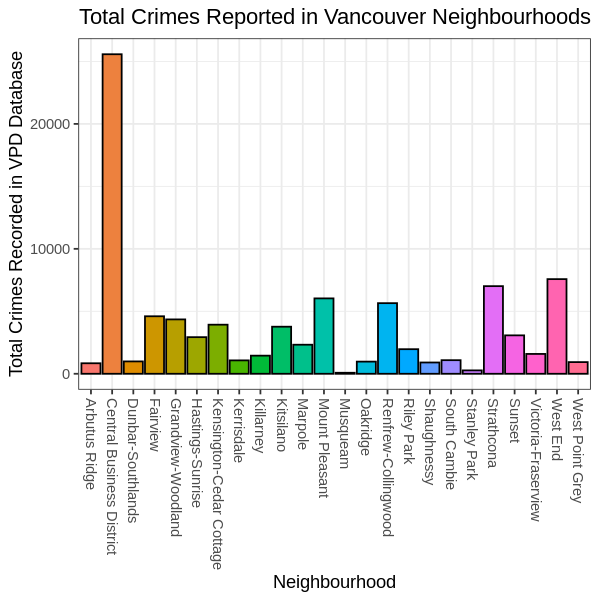

In [9]:
## Processes data for plot
compare_neighbourhood_total_crime <- all_data_tidy_wlockdown |>
    group_by(NEIGHBOURHOOD) |>
    summarize(total_crimes = n(), .groups = "drop") |>
    arrange(desc(total_crimes))

## Plotting
options(repr.plot.width = 5, repr.plot.height = 5) 
compare_neighbourhood_total_crime_plot <- compare_neighbourhood_total_crime |>
    select(NEIGHBOURHOOD, total_crimes) |>
    ggplot(aes(x = NEIGHBOURHOOD, y = total_crimes, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity", color = "black") +
    theme(axis.text.x=element_text(angle=-90, vjust = 0.5, hjust = 0),
          plot.title = element_text(hjust = 0.5),
         legend.position = "none") +
    labs(title = "Total Crimes Reported in Vancouver Neighbourhoods", 
         y = "Total Crimes Recorded in VPD Database", 
         x = "Neighbourhood")
    
## Prints plot
cat("Figure 1\n")
compare_neighbourhood_total_crime_plot

As is seen in the plot above, neighbourhoods such as the Central Business District have a dispropotionately large number of crimes (n = 25576). Certain neighbourhoods have a very low amount of crimes, such as Musqueam (n = 81) and Stanley Park (n = 271). This may lead to some neighbourhoods having a larger effect on overall statistics.

#### **Comparison of Crime Rate in Lockdown vs. Non-Lockdown Periods**

The distributions of daily crime rates were compared for lockdown vs. non-lockdown periods, via boxplots.

#### **Figure 2: Daily Crime Rate in Lockdown vs. Non-Lockdown Periods**

Figure 2
Note: median daily crime rate denoted by dark black vertical line.
      box is drawn from first quartile to third quartile.
      outliers are denoted by individual points.
      *** this is true for all boxplots in this R workbook.


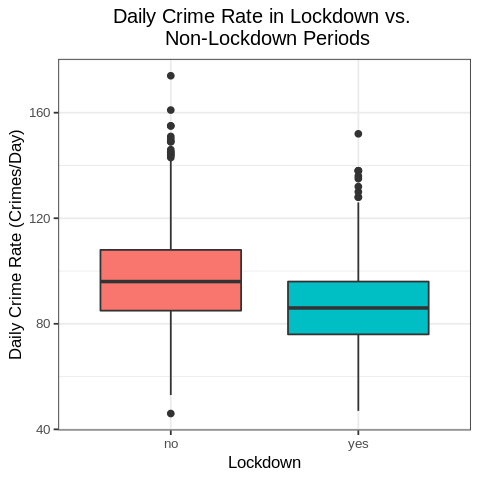

In [10]:
## Plot Data
plot_data_compare_crime_lockdown <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR) |>
    summarize(daily_crimes = n(), .groups = "drop")
 
## Plotting 
options(repr.plot.width = 4, repr.plot.height = 4) 
plot_compare_crime_lockdown <- plot_data_compare_crime_lockdown |>
    ggplot() +
    geom_boxplot(aes(x = lockdown, y = daily_crimes, fill = lockdown)) +
    labs(title = "Daily Crime Rate in Lockdown vs. \n Non-Lockdown Periods", 
         x = "Lockdown",
         y = "Daily Crime Rate (Crimes/Day)") +
    theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 10),
           legend.position = "none")

## Prints plot and figure number/notation
cat("Figure 2\n")
print(plot_compare_crime_lockdown)
cat("Note: median daily crime rate denoted by dark black vertical line.\n",
     "     box is drawn from first quartile to third quartile.\n",
     "     outliers are denoted by individual points.\n",
     "     *** this is true for all boxplots in this R workbook.\n")

The median daily crime rate appears to be slightly lower during lockdown periods from these box plots. This data is summarized in Table 2.

#### **Table 2: Comparison of Daily Crime Rate in Lockdown vs. Non-Lockdown Periods**

In [11]:
## Processes data for table
data_compare_crime_type <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, daily_crimes) |>
    group_by(lockdown) |>
    summarize(median = median(daily_crimes),
              standard_err = sd(daily_crimes), 
              .groups = "drop") |>
    pivot_wider(names_from = lockdown,
                values_from = c(median, standard_err)) |>
    summarize("ΔM" = median_yes - median_no,
              "M Lockdown" = median_yes,
              "M Control" = median_no,
              "S.E. Lockdown" = standard_err_yes,
              "S.E. Control"  = standard_err_no,
              .groups = "drop")


## Prints table
cat("Table 2: Summary of Observed Statistics in Overall Vancouver Population\n")
options(repr.matrix.max.rows = 2)
data_compare_crime_type
cat("M = Median // ΔM = Difference in Medians // S.E. = Standard Error \n")

Table 2: Summary of Observed Statistics in Overall Vancouver Population


ΔM  M Lockdown M Control S.E. Lockdown S.E. Control
1 -10 86         96        18.09264      18.32312

M = Median // ΔM = Difference in Medians // S.E. = Standard Error 


#### **Daily Crime Rate in Lockdown vs. Non-Lockdown for Different Neighbourhoods**

To explore the dataset further, the difference in daily crime rates in different Vancouver neighbourhoods was analyzed.

First, boxplots were generated for all neighbourhoods in the database

#### **Figure 3: Crime Rate in Lockdown vs. Non-Lockdown for Different Neighbourhoods**

Figure 3:


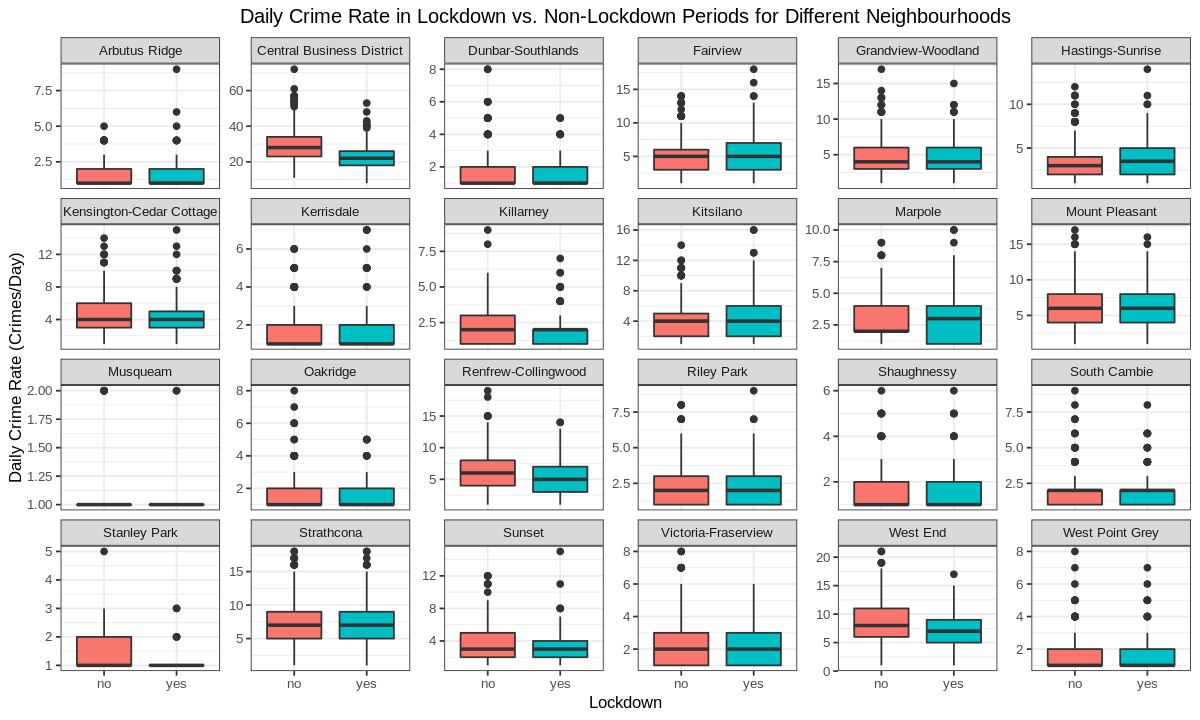

In [12]:
## Plot data
plot_data_compare_crime_neighbourhoods <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR, NEIGHBOURHOOD) |>
    summarize(daily_crimes = n(), .groups = "drop")

## Plotting
options(repr.plot.width = 10, repr.plot.height = 6) 
plot_compare_crime_neighbourhoods <- plot_data_compare_crime_neighbourhoods |>
    ggplot() +
    geom_boxplot(aes(x = lockdown, y = daily_crimes, fill = lockdown)) +
    facet_wrap(facet = vars(NEIGHBOURHOOD), ncol = 6, scales = "free_y") +
    labs(title = "Daily Crime Rate in Lockdown vs. Non-Lockdown Periods for Different Neighbourhoods", 
         x = "Lockdown",
         y = "Daily Crime Rate (Crimes/Day)") +
    theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 10),
           legend.position = "none")

## Print Plot
cat("Figure 3:\n")
plot_compare_crime_neighbourhoods

In general, it appears as though for each neighbourhood, being in lockdown does not affect the median daily crime rate. It appears to be lower for the neighbourhoods Central Business District, Stanley Park, and West End. It should be noted that many of the distributions appear to be right-skewed. This data is summarized in Table 3.

#### **Table 3: Crime Rate in Lockdown vs. Non-Lockdown for Different Neighbourhoods**

In [13]:
## Processes the data for table
data_compare_neighbourhoods <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR, NEIGHBOURHOOD) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, NEIGHBOURHOOD, daily_crimes) |>
    group_by(lockdown, NEIGHBOURHOOD) |>
    summarize(median = median(daily_crimes),
              standard_err = sd(daily_crimes), 
              .groups = "drop") |>
    pivot_wider(names_from = lockdown,
                values_from = c(median, standard_err)) |>
    group_by(NEIGHBOURHOOD) |>
    summarize(NEIGHBOURHOOD,
              "ΔM" = median_yes - median_no,
              "M Lockdown" = median_yes,
              "M Control" = median_no,
              "S.E. Lockdown" = standard_err_yes,
              "S.E. Control"  = standard_err_no,
              .groups = "drop")

## Prints full table
cat("Table 3: Summary of Observed Statistics in Vancouver Neighbourhoods\n")
options(repr.matrix.max.rows = 24)
data_compare_neighbourhoods
cat("M = Median // ΔM = Difference in Medians // S.E. = Standard Error \n")

Table 3: Summary of Observed Statistics in Vancouver Neighbourhoods


NEIGHBOURHOOD             ΔM   M Lockdown M Control S.E. Lockdown
1  Arbutus Ridge              0.0  1.0        1        1.1355011    
2  Central Business District -6.0 22.0       28        6.8902386    
3  Dunbar-Southlands          0.0  1.0        1        0.9871944    
4  Fairview                   0.0  5.0        5        2.8397575    
5  Grandview-Woodland         0.0  4.0        4        2.4287909    
6  Hastings-Sunrise           0.5  3.5        3        2.0379433    
7  Kensington-Cedar Cottage   0.0  4.0        4        2.3685434    
8  Kerrisdale                 0.0  1.0        1        1.2303199    
9  Killarney                  0.0  2.0        2        1.1442595    
10 Kitsilano                  0.0  4.0        4        2.6759982    
11 Marpole                    1.0  3.0        2        1.7714503    
12 Mount Pleasant             0.0  6.0        6        2.9000527    
13 Musqueam                   0.0  1.0        1        0.2578807    
14 Oakridge                   0.0  1.0        1        0.9510343    
15 Renfrew-Collingwood       -1.0  5.0        6        2.8279667    
16 Riley Park                 0.0  2.0        2        1.4453181    
17 Shaughnessy                0.0  1.0        1        1.0329292    
18 South Cambie               0.0  2.0        2        1.2748692    
19 Stanley Park               0.0  1.0        1        0.4564355    
20 Strathcona                 0.0  7.0        7        3.3862675    
21 Sunset                     0.0  3.0        3        1.9579090    
22 Victoria-Fraserview        0.0  2.0        2        1.2931012    
23 West End                  -1.0  7.0        8        2.9965654    
24 West Point Grey            0.0  1.0        1        1.1011050    
   S.E. Control
1  0.8572925   
2  8.2679866   
3  1.1544037   
4  2.5721768   
5  2.3344218   
6  1.9557735   
7  2.2765926   
8  1.0321473   
9  1.2333619   
10 2.3581146   
11 1.6256627   
12 2.8845379   
13 0.3178209   
14 1.0522476   
15 3.0611308   
16 1.4248399   
17 0.9676137   
18 1.2097583   
19 0.6055864   
20 3.2426047   
21 2.1436687   
22 1.3212043   
23 3.5120993   
24 1.0406764

M = Median // ΔM = Difference in Medians // S.E. = Standard Error 


## **Hypothesis Testing**

Hypothesis testing will now be conducted to determine if the differences in medians seen in Figure/Table 3 are significant. 

Structure of Investigation:
1. Test if lockdown days vs. non-lockdown days had a change in crime rate overall
2. Test if lockdown days vs. non-lockdown days had a change in crime rate in specific neighbourhoods 

The null and alternative hypotheses for all hypothesis tests is below. 

**Null hypothesis:** There was no difference in the median daily crime rate in lockdown days vs. non-lockdown days from over the studied days.

$H_0 : M_0 - M_1 = 0$

**Alternative Hypothesis:** There was a difference in the median daily crime rate in lockdown days vs. non-lockdown days over the studied days.

$H_A : M_0 - M_1 \neq 0$

Where,  $M_0$ is the median (or mean) daily crime rate for lockdown days and $M_1$ is the median (or mean) daily crime rate for non-lockdown days.

All tests will use a significance level of 5% ($\alpha = 0.05$). Thus, a p-value of < 0.05 will indicate a significant result.

### Bootstrapping Methods

The process for the bootstrapping hypothesis test using `infer` is as follows:
1. Specified response variable to be `daily_crimes`
2. Set null hypothesis to be `independence` 
3. Generate 1000 bootstrapped samples
4. Calculate the statistic of interest for the bootstrapped samples, ΔM
5. Generate a plot of the null distribution and the observed statistic
6. Calculate a p-value from the null disibtrution relative to the observed statistic

#### Vancouver in Aggregate

First, all crimes in Vancouver in aggregate were studied in lockdown vs. non-lockdown periods.

The observed difference in medians was - 10 crimes/day, as calculated previously. 

The null distribution was generated and is displayed in Figure 4.

Figure 4:
Note: vertical red line represents observed statistic


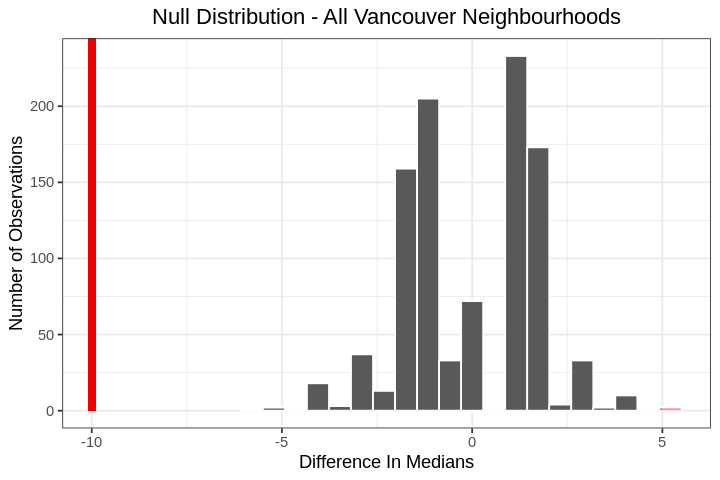

In [14]:
## Sort and aggregate data appropriately
ht_all_btsp_base <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, daily_crimes) 

## Generating null distribution 
ht_all_btsp <- ht_all_btsp_base |>
    specify(formula = daily_crimes ~ lockdown) |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in medians", order = c("no", "yes"))

## Plotting null distribution and observed difference in medians 
ht_all_btsp_plot <- ht_all_btsp |>
    visualize(bins = 20) +
    shade_p_value(obs_stat = -10, direction = "two-sided") + 
    ggtitle("Null Distribution - All Vancouver Neighbourhoods") +
    xlab("Difference In Medians") + 
    ylab("Number of Observations") + 
    theme(plot.title = element_text(hjust = 0.5))
    
cat("Figure 4:\n")
options(repr.plot.width = 6, repr.plot.height = 4) 
ht_all_btsp_plot
cat("Note: vertical red line represents observed statistic\n")

As is demonstrated in the plot above, the observed difference of medians (ΔM = -10) is far outside the expected range. A p-value was calcualted and is reported below

In [15]:
p_val_ht_all_btsp_base <- ht_all_btsp |>
    get_p_value(obs_stat = -10, direction = "both") |>
    select(p_value) |>
    pull()

cat("p-value is:", p_val_ht_all_btsp_base)

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p-value is: 0

Thus, the p-value is < 0.0001 

This indicates that the liklihood of seeing a difference in medians this extreme with an actual difference of medians of 0 is less than 0.01% likely. 

This indicates that we should reject the null hypothesis. This provides evidence of a significant change in the crime rate in Vancouver during lockdown and non-lockdown periods. 

Figure 5:
Note: vertical red line represents observed statistic
      vertical green box represents confidence interval

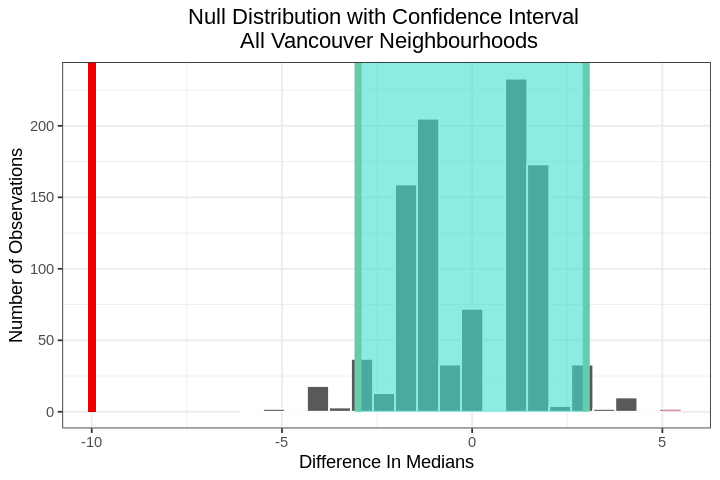

In [16]:
## Measures confidence interval for the bootstrapped distribution
conf_interval_all_btsp <- ht_all_btsp |> 
    select(stat) |>
    get_confidence_interval(level = 0.95, type = "percentile") 

## Generates same plot as Figure 4 but with confidence interval
ht_all_btsp_plot_2 <- ht_all_btsp |>
    visualize(bins = 20) +
    shade_ci(conf_interval_all_btsp) + 
    shade_p_value(obs_stat = -10, direction = "two-sided") + 
    ggtitle("Null Distribution with Confidence Interval \n All Vancouver Neighbourhoods") +
    xlab("Difference In Medians") + 
    ylab("Number of Observations") + 
    theme(plot.title = element_text(hjust = 0.5))

cat("Figure 5:\n")
ht_all_btsp_plot_2
cat("Note: vertical red line represents observed statistic\n")
cat("      vertical green box represents confidence interval")

Consistent with previous results, the confidence interval of the null distribution does not capture the observed difference in medians, indicating a significant result.

#### Neighbourhood-Specific Analysis

This analysis was repeated, but on a neighbourhood-specific level. The data was first filtered by the factor `NEIGHBOURHOOD`. Then, the hypothesis test was repeated on a neighbourhood-specific level. 

In [17]:
## Creating a dataframe base for the for-loop to run on 
neighbourhood_test_base <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR, NEIGHBOURHOOD) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, daily_crimes, NEIGHBOURHOOD) 

## Creating an empty list to store the plots in 
neighbourhood_plots <- list()

## Creating an empty table to store the outputs in 
columns <- c("Neighbourhood", "ΔM", "p_val", "Low CI", "High CI", "fail_h0")
neighbourhood_tests <- data.frame(matrix(ncol = length(columns), nrow = 0))

## For loop - runs over all levels in the factor NEIGHBOURHOOD
for (n in levels(neighbourhood_test_base$NEIGHBOURHOOD)) {
    
    ## Generates a null distribution for the current neighbourhood
    ## stores in response variable to be used for further analysis 
    response <- neighbourhood_test_base |> 
        filter(NEIGHBOURHOOD == n) |>
        specify(formula = daily_crimes ~ lockdown) |>
        hypothesize(null = "independence") |>
        generate(reps = 1000, type = "permute") |>
        calculate(stat = "diff in medians", order = c("no", "yes")) 
    
    ## Pulls relevant observed statistic from table
    observed_stat <- data_compare_neighbourhoods |>
        filter(NEIGHBOURHOOD == n) |>
        select(ΔM) |>
        pull()
    
    ## Measures 95% confidence interval for the current hypothesis test
    conf_interval <- response |>
        get_confidence_interval(level = 0.95, type = "percentile") 
    
    ## Measures two-tailed p-value given the observed statistic 
    p_val <- response |>
        get_p_value(obs_stat = observed_stat, direction = "both")
    
    ## Pulls lower CI from the calculated CI
    ci_lower <- conf_interval |>
        select(lower_ci) |>
        pull()
    
    ## Pulls upper CI from the calculated CI       
    ci_upper <- conf_interval |>
        select(upper_ci) |>
        pull()
    
    ## Creates boolean value if failed or passed the null hypothesis 
    fail_h0 <- (p_val <= 0.05)
   
    ## Creates a new row that is then bound to output dataframe using rbind
    new_obs <- data.frame(n, observed_stat, p_val, ci_lower, ci_upper, fail_h0)
    names(new_obs) <- columns
    neighbourhood_tests <- rbind(neighbourhood_tests, new_obs)
    
    ## Generates a plot of the null distribution for the current hypothesis test
    plot <- response |>
        ggplot(aes(x = stat)) +
        geom_histogram(bins = 10) +
        shade_ci(conf_interval) +
        geom_vline(xintercept = observed_stat, linetype = "solid", color = "red", size = 1) +
        ggtitle(n) + 
        theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 6)) +
        xlab("ΔM") +
        ylab("n")
    
    ## Add plot to list of plots
    neighbourhood_plots[[n]] <- plot
    }


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


The null distributions generated for these hypothesis tests can be seen below, with the measured confidence intervals and difference in medians.

Note that most neighbourhoods appear to have no difference in their median crime rates, as the null distribution CI captures the observed statistic.

Figure 6:
Note: vertical red line represents observed statistic
      vertical green box represents confidence interval

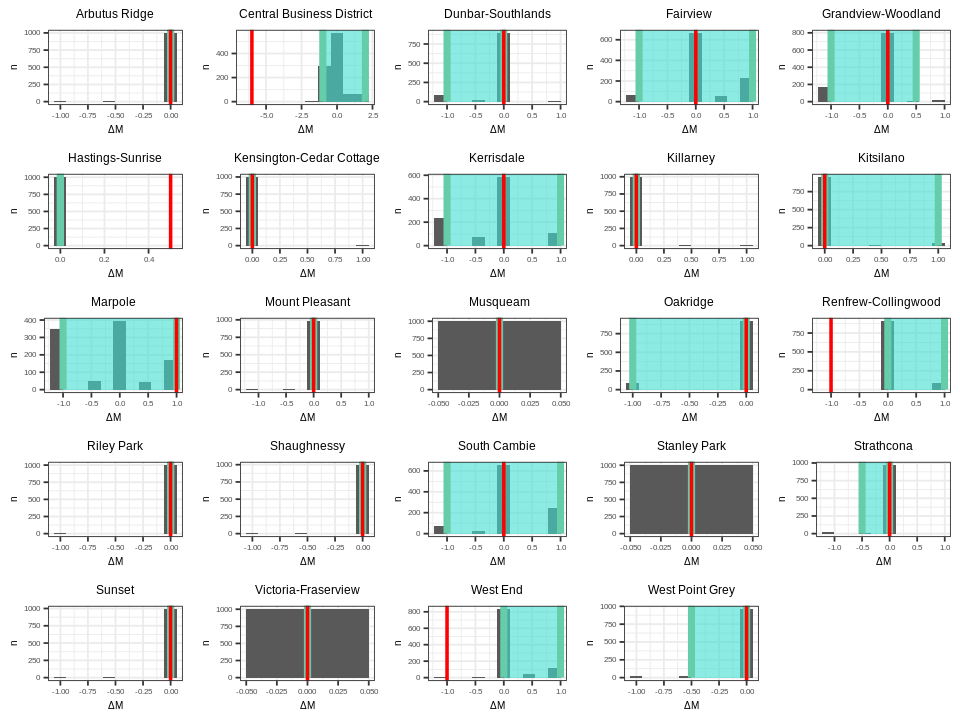

In [18]:
# Use reduce to combine the plots in the plot_list_shaded
options(repr.plot.width = 8, repr.plot.height = 6) 
combined_plot <- plot_grid(plotlist = neighbourhood_plots, ncol = 5, label_size = 4) +
    ggtitle("Null Distributions for Neighbourhood-Specific Hypothesis Tests")

cat("Figure 6:\n")
cat("Note: vertical red line represents observed statistic\n")
cat("      vertical green box represents confidence interval")
combined_plot

The results from the bootstrapping hypothesis test are summarized in Table 4

In [19]:
## Puts passing tests at top of table
neighbourhood_tests <- neighbourhood_tests |>
    arrange(desc(fail_h0))

## Print table
cat("Table 4: Results of Boostrapping Hypothesis Tests for Neighbourhoods\n")
neighbourhood_tests

Table 4: Results of Boostrapping Hypothesis Tests for Neighbourhoods


Neighbourhood             ΔM   p_val Low CI High CI fail_h0
1  Central Business District -6.0 0.000 -1.0   2.0      TRUE  
2  Hastings-Sunrise           0.5 0.000  0.0   0.0      TRUE  
3  Renfrew-Collingwood       -1.0 0.002  0.0   1.0      TRUE  
4  West End                  -1.0 0.006  0.0   1.0      TRUE  
5  Arbutus Ridge              0.0 1.000  0.0   0.0     FALSE  
6  Dunbar-Southlands          0.0 1.000 -1.0   0.0     FALSE  
7  Fairview                   0.0 1.000 -1.0   1.0     FALSE  
8  Grandview-Woodland         0.0 1.000 -1.0   0.5     FALSE  
9  Kensington-Cedar Cottage   0.0 1.000  0.0   0.0     FALSE  
10 Kerrisdale                 0.0 1.000 -1.0   1.0     FALSE  
11 Killarney                  0.0 1.000  0.0   0.0     FALSE  
12 Kitsilano                  0.0 1.000  0.0   1.0     FALSE  
13 Marpole                    1.0 0.336 -1.0   1.0     FALSE  
14 Mount Pleasant             0.0 1.000  0.0   0.0     FALSE  
15 Musqueam                   0.0 1.000  0.0   0.0     FALSE  
16 Oakridge                   0.0 1.000 -1.0   0.0     FALSE  
17 Riley Park                 0.0 1.000  0.0   0.0     FALSE  
18 Shaughnessy                0.0 1.000  0.0   0.0     FALSE  
19 South Cambie               0.0 1.000 -1.0   1.0     FALSE  
20 Stanley Park               0.0 1.000  0.0   0.0     FALSE  
21 Strathcona                 0.0 1.000 -0.5   0.0     FALSE  
22 Sunset                     0.0 1.000  0.0   0.0     FALSE  
23 Victoria-Fraserview        0.0 1.000  0.0   0.0     FALSE  
24 West Point Grey            0.0 1.000 -0.5   0.0     FALSE

In summary, by the bootstrapping methods it appears that Central Business District, Hastings-Sunrise, Renfrew-Collingwood, and West End had a significant change in crimes during lockdown periods.

It should be noted for all tests that failed $H_0$, the CI does not capture the observed statistic.

Hypothesis tests will now be re-conducted using principles of asymptotic statistics.

### Asymptotic Methods

Asymptotic methods assume infinitely large datasets. 

Earlier analysis focussed on the median, however there is no standard asymptotic method for medians.

Thus, means must be compared. To ensure this analysis is simiarly resistant to outliers,  two analyses will be conducted:
1. Two-sample, two-tailed t-test comparing means 
2. Two-sample, two-tailed t-test on bootstrapped distributions of `yes` and `no` lockdown populations

The t-tests will assume unequal varaince, as many of the samples demonstrated this property. 

The test statistic is:  

$Latex Formula to Make$

Degrees of freedom is automatically calculated by `t.test` by the following formula:

$Latex Formula to Make$

The same null hypothesis and alpha value will be used, with $\Delta M \equiv \Delta \mu $ and $M \equiv \mu$


#### Two-Sample Two-Tailed T-Test - Vancouver in Aggregate

A two-sample t-test was conducted to compare the daily crime rate in non-lockdown vs. lockdown periods for Vancouver overall.

In [20]:
## Creates base dataset to conduct t-tests from
t_test_all_base <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, daily_crimes) 

## Creates vector of non-lockdown observations
base_no <- t_test_all_base |>
    filter(lockdown == "no") |>
    select(daily_crimes)

## Creates vector of lockdown observations
base_yes <- t_test_all_base |>
    filter(lockdown == "yes") |>
    select(daily_crimes)

## Runs the t-test
t_test_all <- tidy(t.test(x = base_yes,   ## loads lockdown dataset 
                          y = base_no,    ## loads non-lockdown dataset
                          mu = 0,         ## alternative: no difference
                          alternative = "two.sided", ##   and two-sided
                          var.equal = FALSE,  ## varainces are unequal
                          conf.level = 0.95,  ## 95% confidence level
                         ))

cat("Results of Non-Bootstrapped T-Test // All Neighbourhoods\n")
cat("Test Statistic     : ", t_test_all$statistic, "\n")
cat("Degrees of Freedom : ", t_test_all$parameter, "\n")
cat("Observed dMeans    : ", t_test_all$estimate, "\n")
cat("P-Value            : ", t_test_all$p.value, "\n")
cat("Low CI dMeans      : ", t_test_all$conf.low, "\n")
cat("High CI dMeans     : ", t_test_all$conf.high, "\n")

Results of Non-Bootstrapped T-Test // All Neighbourhoods
Test Statistic     :  -7.281905 
Degrees of Freedom :  527.5021 
Observed dMeans    :  -9.431076 
P-Value            :  1.204086e-12 
Low CI dMeans      :  -11.97534 
High CI dMeans     :  -6.886814 


As seen above, the t-test concludes with p < 0.0001 that there was a significant change in daily crime rates between the two periods. This change is measured with 95% confidence to be [- 6.88, - 11.99]. As the CI does not capture $\Delta \mu = 0$, this indicates with 95% confidence there is a change. 

This investigation was repeated for all neighbourhoods.

#### Two-Sample Two-Tailed T-Test - Vancouver Neighbourhoods

In [21]:
## Creates base dataframe for for-loop to run on 
neighbourhood_t_test_base <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR, NEIGHBOURHOOD) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, daily_crimes, NEIGHBOURHOOD) 

## Filters non-lockdown days 
t_test_base_no <- neighbourhood_t_test_base |>
    filter(lockdown == "no") 

## Filters lockdown days
t_test_base_yes <- neighbourhood_t_test_base |>
    filter(lockdown == "yes") 

## Sets up table for outputs 
columns <- c("Neighbourhood", "T-Stat", "d.f.", "dMeans", "CI low", "CI high", "p-value", "fail_h0")
neighbourhood_t_tests <- data.frame(matrix(ncol = length(columns), nrow = 0))

for (n in levels(neighbourhood_t_test_base$NEIGHBOURHOOD)) {
    
    ## Separates non-lockdown days for analysis
    n_base_no <- t_test_base_no |>
        filter(NEIGHBOURHOOD == n) |>
        select(daily_crimes)
    
    ## Separates lockdown days for analysis
    n_base_yes <- t_test_base_yes |>
        filter(NEIGHBOURHOOD == n) |>
        select(daily_crimes)
    
    ## Runs the t-test and stores output in response 
    response <- tidy(t.test(x = n_base_yes, 
                            y = n_base_no,
                            mu = 0,
                            alternative = "two.sided", 
                            var.equal = FALSE,
                            conf.level = 0.95))
    
    t_stat <- response$statistic
    df <- response$parameter
    p_val <- response$p.value
    dMeans <- response$estimate
    ci_lower <- response$conf.low  
    ci_upper <- response$conf.high
    
    fail_h0 <- (p_val <= 0.05)
    
    new_obs <- data.frame(n, t_stat, df, dMeans, ci_lower, ci_upper, p_val, fail_h0)
    names(new_obs) <- columns
    
    neighbourhood_t_tests <- rbind(neighbourhood_t_tests, new_obs)

    }


The results of the t-tests done on the neighbourhood-specific level are summarized in Table 5

In [22]:
cat("Table 5: Results of T-Tests for Neighbourhoods in Vancouver \n")
arrange(neighbourhood_t_tests, desc(fail_h0))

Table 5: Results of T-Tests for Neighbourhoods in Vancouver 


Neighbourhood             T-Stat       d.f.      dMeans       CI low     
t1  Central Business District -12.78484036 620.19415 -6.677613097 -7.70331792
t5  Hastings-Sunrise            2.87213880 475.20409  0.426797126  0.13480464
t9  Kitsilano                   2.04716958 454.91919  0.384514436  0.01539756
t14 Renfrew-Collingwood        -3.41911211 564.27265 -0.708400845 -1.11535581
t18 Stanley Park               -2.18474138 103.64307 -0.176161262 -0.33606511
t20 Sunset                     -4.94036695 474.81466 -0.751059211 -1.04978416
t22 West End                   -6.87342982 603.80068 -1.550359712 -1.99333396
t   Arbutus Ridge               1.74612490 200.90889  0.184498480 -0.02384964
t2  Dunbar-Southlands          -0.73759239 361.08478 -0.071084337 -0.26060811
t3  Fairview                    0.84742310 470.52711  0.168623230 -0.22238306
t4  Grandview-Woodland         -0.32684254 491.19341 -0.056530868 -0.39636468
t6  Kensington-Cedar Cottage   -0.32730211 493.51125 -0.055301180 -0.38727213
t7  Kerrisdale                  0.66124017 293.15245  0.069277108 -0.13691655
t8  Killarney                  -1.51898511 409.34210 -0.147210434 -0.33772103
t10 Marpole                     0.34787515 395.12553  0.046451133 -0.21606338
t11 Mount Pleasant             -1.93422962 518.14291 -0.400436015 -0.80714975
t12 Musqueam                   -0.62564325  68.11298 -0.042145594 -0.17656357
t13 Oakridge                    0.20820771 317.35502  0.019100288 -0.16138866
t15 Riley Park                 -0.30407978 442.80781 -0.033908699 -0.25306822
t16 Shaughnessy                 0.47241255 287.50515  0.044973545 -0.14240326
t17 South Cambie                0.40820841 336.08307  0.046131165 -0.17616264
t19 Strathcona                 -0.44318534 499.44945 -0.105863580 -0.57517701
t21 Victoria-Fraserview         0.03745995 390.65383  0.003988766 -0.20535835
t23 West Point Grey             0.46553613 306.46435  0.046850998 -0.15117949
    CI high      p-value      fail_h0
t1  -5.651908273 2.186477e-33  TRUE  
t5   0.718789615 4.259334e-03  TRUE  
t9   0.753631308 4.121537e-02  TRUE  
t14 -0.301445883 6.736243e-04  TRUE  
t18 -0.016257414 3.116091e-02  TRUE  
t20 -0.452334261 1.082420e-06  TRUE  
t22 -1.107385462 1.566321e-11  TRUE  
t    0.392846600 8.231773e-02 FALSE  
t2   0.118439440 4.612412e-01 FALSE  
t3   0.559629522 3.971902e-01 FALSE  
t4   0.283302948 7.439262e-01 FALSE  
t6   0.276669773 7.435782e-01 FALSE  
t7   0.275470767 5.089777e-01 FALSE  
t8   0.043300167 1.295382e-01 FALSE  
t10  0.308965648 7.281192e-01 FALSE  
t11  0.006277715 5.362903e-02 FALSE  
t12  0.092272380 5.336398e-01 FALSE  
t13  0.199589235 8.352003e-01 FALSE  
t15  0.185250818 7.612100e-01 FALSE  
t16  0.232350355 6.369907e-01 FALSE  
t17  0.268424970 6.833806e-01 FALSE  
t19  0.363449846 6.578236e-01 FALSE  
t21  0.213335881 9.701374e-01 FALSE  
t23  0.244881483 6.418782e-01 FALSE

As it can be observed above, 7 neighbourhoods in the t-tests indicate that the null hypothesis should be rejected. I.e. there was a significant change in crime.

There were three additional neighbourhoods that were detected to have a change in crime: Kitsilano, Stanley Park, and Sunset. 

#### Two-Sample Two-Tailed T-Test on Mean Difference with Bootstrapped Distributions

To ensure the skew of datasets had minimal effects on the conclusions of the t-tests, the negihbourhood-specific analysis was reconducted on bootstrapped distributions of the lockdown and non-lockdown daily crimes. This allows us to come closer to the assumption of the t-test, that dataset is sufficiently large and normally-distributed.

In [23]:
## Creates base dataframe for for-loop to run on 
neighbourhood_t_test_base_btsp <- all_data_tidy_wlockdown |>
    group_by(lockdown, DAY, MONTH, YEAR, NEIGHBOURHOOD) |>
    summarize(daily_crimes = n(), .groups = "drop") |>
    select(lockdown, daily_crimes, NEIGHBOURHOOD) 

## Filters non-lockdown days 
t_test_base_no <- neighbourhood_t_test_base_btsp |>
    filter(lockdown == "no") 

## Filters lockdown days
t_test_base_yes <- neighbourhood_t_test_base_btsp |>
    filter(lockdown == "yes") 

## Sets up table for outputs 
columns <- c("Neighbourhood", "T-Stat", "d.f.", "dMeans", "CI low", "CI high", "p-value", "fail_h0")
neighbourhood_t_tests_btsp <- data.frame(matrix(ncol = length(columns), nrow = 0))

for (n in levels(neighbourhood_t_test_base_btsp$NEIGHBOURHOOD)) {
    
    ## Separates non-lockdown days for analysis
    n_base_no <- t_test_base_no |>
        filter(NEIGHBOURHOOD == n) |>
        specify(response = daily_crimes) |>
        generate("bootstrap", reps = 1000) |>
        select(daily_crimes)
    
    ## Separates lockdown days for analysis
    n_base_yes <- t_test_base_yes |>
        filter(NEIGHBOURHOOD == n) |>
        specify(response = daily_crimes) |>
        generate("bootstrap", reps = 1000)  |>
        select(daily_crimes)

    ## Runs the t-test and stores output in response 
    response <- tidy(t.test(x = n_base_yes, 
                            y = n_base_no,
                            mu = 0,
                            alternative = "two.sided", 
                            var.equal = FALSE,
                            conf.level = 0.95))
    
    t_stat <- response$statistic
    df <- response$parameter
    p_val <- response$p.value
    dMeans <- response$estimate
    ci_lower <- response$conf.low  
    ci_upper <- response$conf.high
    
    fail_h0 <- (p_val <= 0.05)
    
    new_obs <- data.frame(n, t_stat, df, dMeans, ci_lower, ci_upper, p_val, fail_h0)
    names(new_obs) <- columns
    
    neighbourhood_t_tests_btsp <- rbind(neighbourhood_t_tests_btsp, new_obs)

    }

Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missing grouping variables: `replicate`
Adding missin

The results of the t-tests done on the bootstrapped distributions is summarized in Table 6.

In [24]:
cat("Table 6: Results of T-Tests on Boostrapped Distributions for Neighbourhoods in Vancouver \n")
arrange(neighbourhood_t_tests_btsp, fail_h0)

Table 6: Results of T-Tests on Boostrapped Distributions for Neighbourhoods in Vancouver 


Neighbourhood             T-Stat      d.f.      dMeans       CI low    
t   Arbutus Ridge              0.12613119  501537.9  0.089993085 -1.3084210
t2  Dunbar-Southlands         -0.05076721  626417.1 -0.033902610 -1.3427794
t3  Fairview                   0.16956143 1029797.5  0.087643011 -0.9254255
t4  Grandview-Woodland        -0.06043714 1021317.6 -0.031258345 -1.0449613
t5  Hastings-Sunrise           0.41513434  990179.3  0.220284650 -0.8197414
t6  Kensington-Cedar Cottage  -0.05389296 1026162.3 -0.027937839 -1.0439744
t7  Kerrisdale                 0.05676162  684238.5  0.036501539 -1.2238894
t8  Killarney                 -0.11731234  767018.6 -0.069947944 -1.2385860
t9  Kitsilano                  0.37271033 1018969.3  0.194531700 -0.8284493
t10 Marpole                    0.03074706  854738.0  0.017062988 -1.0706147
t11 Mount Pleasant            -0.39191009 1044482.8 -0.200835922 -1.2052286
t12 Musqueam                  -0.01197516  123721.7 -0.020565517 -3.3865378
t13 Oakridge                   0.01359639  580961.0  0.009166318 -1.3121910
t14 Renfrew-Collingwood       -0.67877858 1051185.6 -0.347854741 -1.3522818
t15 Riley Park                -0.02540720  900716.3 -0.014173669 -1.1075612
t16 Shaughnessy                0.03235155  612999.8  0.021893739 -1.3045041
t17 South Cambie               0.03284670  708112.5  0.021318352 -1.2507508
t18 Stanley Park              -0.07559496  161361.8 -0.088810818 -2.3914421
t19 Strathcona                -0.10451371 1041787.5 -0.053426494 -1.0553441
t20 Sunset                    -0.69467938  875706.1 -0.377771910 -1.4436166
t21 Victoria-Fraserview        0.00180015  769711.7  0.001061016 -1.1541524
t22 West End                  -1.52223644 1040754.6 -0.778322901 -1.7804580
t23 West Point Grey            0.03353135  648328.0  0.022460733 -1.2904096
t1  Central Business District -6.69440788 1038905.7 -3.348402838 -4.3287370
    CI high    p-value      fail_h0
t    1.4884072 8.996281e-01 FALSE  
t2   1.2749742 9.595110e-01 FALSE  
t3   1.1007115 8.653551e-01 FALSE  
t4   0.9824446 9.518075e-01 FALSE  
t5   1.2603107 6.780437e-01 FALSE  
t6   0.9880987 9.570205e-01 FALSE  
t7   1.2968925 9.547351e-01 FALSE  
t8   1.0986901 9.066126e-01 FALSE  
t9   1.2175127 7.093641e-01 FALSE  
t10  1.1047407 9.754713e-01 FALSE  
t11  0.8035568 6.951247e-01 FALSE  
t12  3.3454068 9.904454e-01 FALSE  
t13  1.3305237 9.891520e-01 FALSE  
t14  0.6565723 4.972783e-01 FALSE  
t15  1.0792139 9.797302e-01 FALSE  
t16  1.3482915 9.741917e-01 FALSE  
t17  1.2933875 9.737968e-01 FALSE  
t18  2.2138204 9.397414e-01 FALSE  
t19  0.9484911 9.167617e-01 FALSE  
t20  0.6880728 4.872564e-01 FALSE  
t21  1.1562744 9.985637e-01 FALSE  
t22  0.2238122 1.279502e-01 FALSE  
t23  1.3353311 9.732509e-01 FALSE  
t1  -2.3680687 2.166560e-11  TRUE

Now, only the central business district passes the hypothesis test. This is understandbale as this district had the most distinct difference in the bootstrapping methods.

This may indicate this test has lower power but is trustful.

### Comparison of Asymptotic and Bootstrapping Methods

A summary of the hypothesis tests results seen for the various neighbourhoods is seen in Table 7.

In [25]:
## Grabs results for bootstrapping hypothesis test
btsp_results <- neighbourhood_tests |>
    select(Neighbourhood, fail_h0) |>
    mutate(Pass_BTSP_HT = fail_h0) |>
    arrange(Neighbourhood) |>
    select(Neighbourhood, Pass_BTSP_HT)

## Grabs results from t-tests
t_test_results <- neighbourhood_t_tests |>
    select(Neighbourhood, fail_h0) |>
    mutate(Pass_T_HT = fail_h0) |>
    arrange(Neighbourhood) |>
    select(Pass_T_HT)

## Grabs results from bootstrapped population t-tests
t_test_btsp_results <- neighbourhood_t_tests_btsp |>
    select(Neighbourhood, fail_h0) |>
    mutate(Pass_T_BTSP_HT = fail_h0) |> 
    arrange(Neighbourhood) |>
    select(Pass_T_BTSP_HT)

## Compiles into a single table
hypo_test_results <- bind_cols(btsp_results, t_test_results, t_test_btsp_results) |>
    arrange(desc(Pass_T_HT))

## Prints only rows with conflicting results
cat("Table 7: Neighbourhoods with Conflicting Hypothesis Test Results \n")
head(hypo_test_results, n = 7)

Table 7: Neighbourhoods with Conflicting Hypothesis Test Results 


Neighbourhood             Pass_BTSP_HT Pass_T_HT Pass_T_BTSP_HT
t1  Central Business District  TRUE        TRUE       TRUE         
t5  Hastings-Sunrise           TRUE        TRUE      FALSE         
t9  Kitsilano                 FALSE        TRUE      FALSE         
t14 Renfrew-Collingwood        TRUE        TRUE      FALSE         
t18 Stanley Park              FALSE        TRUE      FALSE         
t20 Sunset                    FALSE        TRUE      FALSE         
t22 West End                   TRUE        TRUE      FALSE

An interesting point to note is that the Central Business District was the only neighbourhood to have significant findings in three hypothesis tests. Stanley Park, Kitsilano and Sunset only had significant findings in a single hypothesis test.

These populations will be explored further to determine if they have properties that resulted in these discrepancies.

First, the total number of in lockdown vs. non-lockdown periods was determined. 

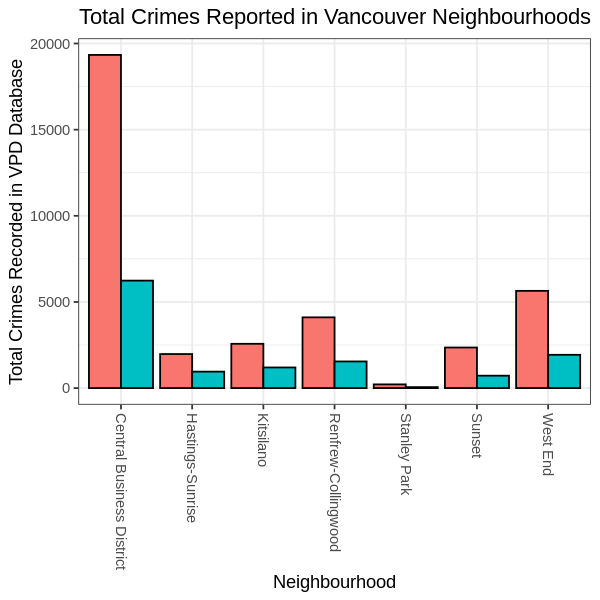

In [26]:
analyze_size_failed_tests <- all_data_tidy_wlockdown |>
    filter(NEIGHBOURHOOD %in% c("Central Business District", "Hastings-Sunrise", "Renfrew-Collingwood", "West End", "Kitsilano", "Stanley Park", "Sunset")) |>
    group_by(NEIGHBOURHOOD, lockdown) |>
    summarize(total_crimes = n(), .groups = "drop")

options(repr.plot.width = 5, repr.plot.height = 5) 
analyze_size_failed_tests_plot <- analyze_size_failed_tests |>
    ggplot(aes(x = NEIGHBOURHOOD, y = total_crimes, fill = lockdown)) +
    geom_bar(position = "dodge", stat = "identity", color = "black") +
    theme(axis.text.x=element_text(angle=-90, vjust = 0.5, hjust = 0),
          plot.title = element_text(hjust = 0.5),
         legend.position = "none") +
    labs(title = "Total Crimes Reported in Vancouver Neighbourhoods", 
         y = "Total Crimes Recorded in VPD Database", 
         x = "Neighbourhood")

analyze_size_failed_tests_plot

As noted before, the number of observations is much lower for some neighbourhoods. Especially Stanley Park.

The distribution of daily crime rates was generated for these neighbourhoods, to observe skew and non-normality properties of data.

`summarise()` has grouped output by 'YEAR', 'MONTH', 'DAY', 'NEIGHBOURHOOD'.
You can override using the `.groups` argument.


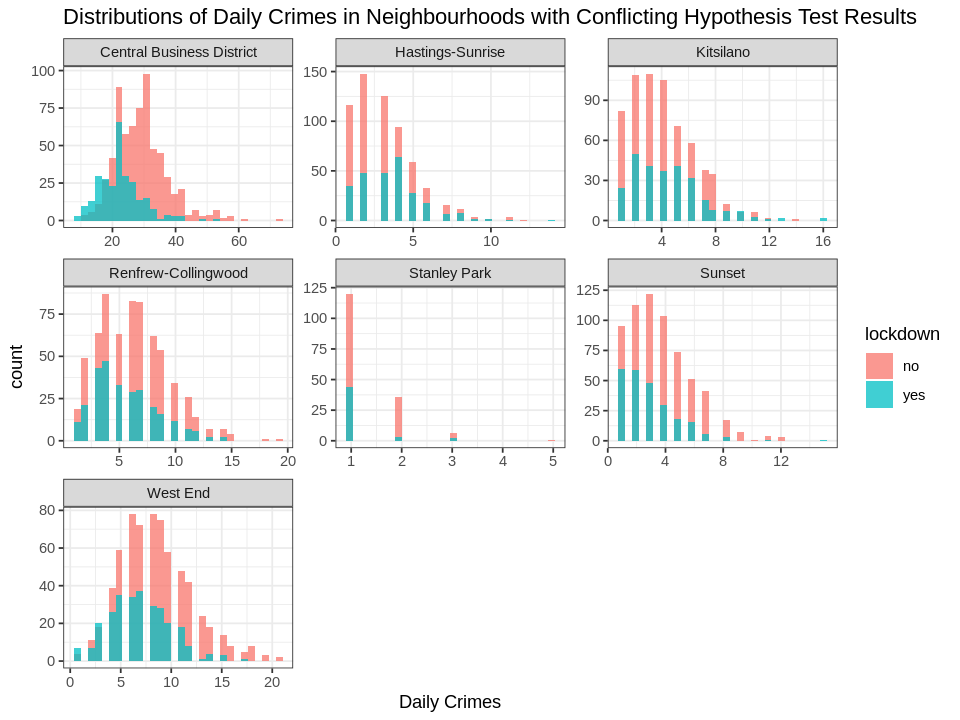

In [27]:
## Filters only neighbourhoods with conflicting results
analyze_failed_h0_t_test <- all_data_tidy_wlockdown |>
    filter(NEIGHBOURHOOD %in% c("Central Business District", "Hastings-Sunrise", "Renfrew-Collingwood", "West End", "Kitsilano", "Stanley Park", "Sunset"))

## Measures daily crime rates
analyze_failed_h0_t_test <- analyze_failed_h0_t_test |>
    group_by(YEAR, MONTH, DAY, NEIGHBOURHOOD, lockdown) |>
    summarize(daily_crimes = n())

options(repr.plot.width = 8, repr.plot.height = 6)
## Plots histogram of distribution of daily crime rates
analyze_failed_tests_plot <- analyze_failed_h0_t_test |>
    ggplot(aes(x = daily_crimes, fill = lockdown)) +
    geom_histogram(bins = 30, position = "identity", alpha = 0.75) +
    facet_wrap(facet = vars(NEIGHBOURHOOD), ncol = 3, scales = "free") +
    labs(x = "Daily Crimes",
         x = "Count", 
         title = "Distributions of Daily Crimes in Neighbourhoods with Conflicting Hypothesis Test Results")

## Prints plot
analyze_failed_tests_plot

This plot may indicate why some neighbourhoods had conflicting results. The t-test assumes normality of data. Kitsilano, Stanley Park, and Sunset are right-skewed datasets.

# Discussion
***


Recall the following t-test assumptions:
1. There is homogeneity of variance between samples
2. The distributions are approximately normal 
3. The assumptions of the CLT are met 


T-tests with medians 

Typically, always want to do non-parametric tests with medians, unless they fit the sample size requirement well enough

Doing t-tests with mean (as that is correct) assuming median approx == mean, but this is less true with smaller, non-skewed dataset

Non-parametric does not rely on a known probability distribution

Why better? (Paramteric)
- Works with small sample size and data potentially non-normal 
- No need to remove outliers, etc
- Median is a better measure for this (as we're trying to see long-term trends and there are days with outliers) so thus a non-parametric is correct

##### **What do you expect to find?**

This study hopes to find out the impact of the epidemic on crime rates in Vancouver communities by compiling and analysing crime data. It is generally believed that during the outbreak, the world economy is in recession and the unemployment rate is rising, which may lead to an increase in the probability of crime. However, our analysis is likely to find the opposite trend. 

##### **What impact could such findings have?**
Determining causational relationships for crime-rates can shape and policies aimed to reduce crime. Currently, the understanding is that lockdowns caused a large increase in crime, however, it is our aim to separate the effects of lockdown from the general effects of COVID on soceity.

##### **What future questions could this lead to?**
1. Can lockdown policies be subdivided into smaller groups (mask-wearing, gym closures, bar closures) to determine their individual effects on crime rates? 
2. Would this analysis generate the same results if the data was obtained from a different geographic region than Vancouver? 


# References 
***

1. Urrutia, D., Manetti, E., Williamson, M., & Lequy, E. (2021). Overview of Canada’s answer to the COVID-19 pandemic’s first wave (January–April 2020). International Journal of Environmental Research and Public Health, 18(13), 7131.

2. Munro, R., "Covid-19: A timeline of the pandemic and how it changed our lives over the past two years". INFOnews. Available: https://infotel.ca/newsitem/covid-19-a-timeline-of-the-pandemic-and-how-it-changed-our-lives-over-the-past-two-years/it88449. [Accessed 18 March 2023]

3. Andresen, M. A., & Hodgkinson, T. (2022). In a world called catastrophe: the impact of COVID-19 on neighbourhood level crime in Vancouver, Canada. Journal of Experimental Criminology, 1-25.

4. The Vancouver Police Department, "VPD GeoDash Crime Map,"
[Online]. Available: http://geodash.vpd.ca/. [Accessed 09 March 2023].